Baseline TODOs:
- Test effect of different pos_weight visually

Improvements predictors:
- Use day of year as predictor to model distrbituion change? Probably too sparse, should rather use month
- Add in embedded satellite data surrounding location

In [2]:
#import stuff
import torch
import hydra
import wandb
import json
import os
import pandas as pd
import numpy as np
import pytorch_lightning as pl

from dataset import SINR_DS
from models import SINR_Net

import sys
sys.path.append('/home/jdolli/')
from sentinel2_foundation_model.models import Sent2AE as Sent2VAE, View

In [3]:
# dataset_file = pd.read_csv('/data/jdolli/Presences_only_train.csv', sep=";", header='infer', low_memory=False)
dataset_file = pd.read_csv('/data/jdolli/Pot_10_to_1000.csv', sep=";", header='infer', low_memory=False)
# PREDICTORS = "loc_env_sent2"
PREDICTORS = "loc"

In [4]:
BATCHSIZE = 2048
dataset = SINR_DS(dataset_file, PREDICTORS)
ds_train, ds_val = torch.utils.data.random_split(dataset, [0.9, 0.1])
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=BATCHSIZE, num_workers=16)
val_loader = torch.utils.data.DataLoader(ds_val, batch_size=BATCHSIZE, num_workers=16)

In [5]:
#create model
class SINR(pl.LightningModule):
    def __init__(self, params, dataset, **kwargs):
        super().__init__(**kwargs)
        
        input_len = 4
        if "env" in params["predictors"]:
            input_len += 20
        
        self.params = params
        if params["model"] == "log_reg":
            self.net = torch.nn.Linear(input_len, 10040)
        elif "sinr" in params["model"]:
            self.net = SINR_Net(input_len, hidden_dim = params["sinr_hidden"], dropout = params["dropout"], layers = params["sinr_layers"])
        self.dataset = dataset
        self.val_data = dataset.val_data
        self.cutoff = 0.5
        
        if "env" in params["predictors"]:
            data_path = os.path.join("/data/jdolli/glc23_data/sinr_data/data/env/",'bioclim_elevation_scaled.npy')
            context_feats = np.load(data_path).astype(np.float32)
            context_feats = torch.from_numpy(context_feats)
        
        self.save_hyperparameters()
        
    def forward(self, x):
        return self.net(x)
    
    def apply_model_and_an_full_loss(self, batch, dataset, params):
        loc_features, labels = batch
        random_loc_features = dataset.sample_encoded_locs(len(batch)).to(labels.device)

        loc_pred = torch.sigmoid(self(loc_features))
        rand_pred = torch.sigmoid(self(random_loc_features))

        inds = torch.arange(len(labels))

        loss_pos = -torch.log((1 - loc_pred) + 1e-5)
        loss_bg = -torch.log((1 - rand_pred) + 1e-5)
        loss_pos[inds, labels] = params["pos_weight"] * -torch.log(loss_pos[inds, labels] + 1e-5)

        return loss_pos.mean() + loss_bg.mean()

    def training_step(self, batch, batch_nb):
        loss = self.apply_model_and_an_full_loss(batch, self.dataset, self.params)
        loss_detached = loss.detach().cpu()
        log_dict = {"train_loss": loss_detached}
        self.log_dict(log_dict, batch_size=len(batch))
        return {"loss": loss, "progress_bar": float(loss_detached)}
    
    def validation_step(self, batch, batch_nb):
        device = batch[1].device
        
        loss = self.apply_model_and_an_full_loss(batch, self.dataset, self.params)
        loss_detached = loss.detach().cpu()
        log_dict = {"val_loss": loss_detached}
        
        if batch_nb == 0:
            micro_f1_cutoff = 0
            micro_f1_top20 = 0
            PP_cutoff = 0
            for key in self.val_data.keys():
                splt_key = key.split("/")
                lon = float(splt_key[0])
                lat = float(splt_key[1])
                pred = self.net(self.dataset.encode(lon, lat).to(device))
                top_20 = torch.zeros(10040).to(device)
                top_20[torch.topk(pred, 20).indices] = 1
                above_cutoff = (torch.sigmoid(pred) > self.cutoff).int()
                occs = torch.zeros(10040).to(device)
                occs[self.val_data[key]] = 1
                
                PP_cutoff += above_cutoff.sum()
                TP = (above_cutoff * occs).sum()
                FP = (above_cutoff * (1 - occs)).sum()
                FN = ((1 - above_cutoff) * occs).sum()
                if TP > 0:
                    micro_f1_cutoff += TP / (TP + (FP + FN) / 2)
                else:
                    micro_f1_cutoff += 0
                            
                TP = (top_20 * occs).sum()
                FP = (top_20 * (1 - occs)).sum()
                FN = ((1 - top_20) * occs).sum()
                if TP > 0:
                    micro_f1_top20 += TP / (TP + (FP + FN) / 2)
                else:
                    micro_f1_top20 += 0
            
            log_dict["micro_f1_cutoff"] = micro_f1_cutoff/len(self.val_data)
            log_dict["micro_f1_top20"] = micro_f1_top20/len(self.val_data)
            log_dict["predicted_present_cutoff"] = PP_cutoff/len(self.val_data)
        
                   
        self.log_dict(log_dict, batch_size=len(batch))
        return {"loss": loss, "progress_bar": float(loss_detached)}
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr=self.params["lr"],
                              weight_decay = self.params["l2_dec"])
        return opt

In [6]:
class SAT_SINR_LF(SINR):
    def __init__(self, params, dataset, **kwargs):
        super().__init__(params, dataset, **kwargs)
        self.sent2_net = torch.load("/home/jdolli/sentinel2_foundation_model/best_model.pt").encoder.to("cpu")
        self.sent2_to_classes = torch.nn.Linear(256, 10040)
        
    def forward(self, x, no_sent2 = True):
        if no_sent2:
            return self.net(x)
        enc, sent2 = x
        sent2_enc = self.sent2_net(sent2)
        return self.net(enc) * self.sent2_to_classes(sent2_enc)
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(list(self.net.parameters()) + list(self.sent2_to_classes.parameters()), lr=self.params["lr"],
                              weight_decay = self.params["l2_dec"])
        return opt
    
    def apply_model_and_an_full_loss(self, batch, dataset, params):
        # TODO: Also get satellite images for random locations
        loc_features, sent2_images, labels = batch
        random_loc_features = dataset.sample_encoded_locs(len(batch)).to(labels.device)

        loc_pred = torch.sigmoid(self((loc_features, sent2_images), no_sent2 = False))
        rand_pred = torch.sigmoid(self(random_loc_features))

        inds = torch.arange(len(labels))

        loss_pos = -torch.log((1 - loc_pred) + 1e-5)
        loss_bg = -torch.log((1 - rand_pred) + 1e-5)
        loss_pos[inds, labels] = params["pos_weight"] * -torch.log(loss_pos[inds, labels] + 1e-5)

        return loss_pos.mean() + loss_bg.mean()
    
    # TODO: Fix the val data loading in validation step (need to redo the file so it includes patchID)

In [7]:
default_params = {"pos_weight": 2048, "lr": 5e-4, "l2_dec": 0, "epochs": 40, "model": "sat_sinr_lf", "predictors": PREDICTORS, "sinr_layers": 4, "sinr_hidden": 256, "dropout": 0.5}
model = SAT_SINR_LF(default_params, dataset)
# model.validation_step(next(iter(train_loader)), 0)

In [8]:
#set up training

torch.set_float32_matmul_precision('medium')
CLUSTER = True

def train_model(params, tag=""):
    if params["model"] == "sinr" or params["model"] == "log_reg":
        model = SINR(params, dataset)
    elif params["model"] == "sat_sinr_lf":
        model = SAT_SINR_LF(params, dataset)
    
    name = params["model"] + " " + params["predictors"] + " " + tag
    
    logger = hydra.utils.instantiate({"_target_": "pytorch_lightning.loggers.WandbLogger",
            "name": name,
            "save_dir": "/home/jdolli/geolifeclef_playground/wandb_logs" if CLUSTER
                                      else "/home/eco08/PycharmProjects/geolifeclef_playground/wandb_logs",
            "project": "sinr_on_glc23"})

    """filename = "cp-{val_loss:.4f}-{epoch:02d}-"
    checkpoint_callback = ModelCheckpoint(
        save_top_k=1,
        monitor="val_loss",
        mode="min",
        dirpath="./checkpoints",
        filename="/data/jdolli/data/BDC/" + ds_name + "_" + filename,
    )"""
    
    trainer = pl.Trainer(max_epochs=params["epochs"], accelerator="gpu", devices=1,
                         precision=16, logger=logger, log_every_n_steps=50)
                         #callbacks=[checkpoint_callback])
    trainer.fit(model, train_loader, val_loader)

    wandb.finish()

In [ ]:
wandb.finish()
params = {"pos_weight": 2048, "lr": 5e-4, "l2_dec": 0, "epochs": 2, "model": "log_reg", "predictors": PREDICTORS, "sinr_layers": 4, "sinr_hidden": 256, "dropout": 0.5}
#log_reg
train_model(params, tag="")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johannes-dollinger (ecovision). Use `wandb login --relogin` to force relogin


/home/jdolli/data/conda/envs/glc23/lib/python3.9/site-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | net  | Linear | 50.2 K
--------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
params = {"pos_weight": 2048, "lr": 5e-4, "l2_dec": 0, "epochs": 10, "model": "sinr", "predictors": PREDICTORS, "sinr_layers": 4, "sinr_hidden": 256, "dropout": 0.5}
#log_reg
for sinr_layers in [2, 8]:
    params["sinr_layers"] = sinr_layers
    train_model(params)

In [ ]:
params = {"pos_weight": 2048, "lr": 5e-4, "l2_dec": 0, "epochs": 10, "model": "sinr", "predictors": PREDICTORS, "sinr_layers": 4, "sinr_hidden": 256, "dropout": 0.5}
#log_reg
for pos_weight in [1024, 4096]:
    params["pos_weight"] = pos_weight
    train_model(params)

In [ ]:
params = {"pos_weight": 2048, "lr": 5e-4, "l2_dec": 0, "epochs": 10, "model": "sinr", "predictors": PREDICTORS, "sinr_layers": 4, "sinr_hidden": 256, "dropout": 0.5}
#log_reg
for dropout in [0.2, 0.8]:
    params["dropout"] = dropout
    train_model(params)

In [22]:
# Create output images for multiple species
import random
from collections import Counter

NUM_SAMPLES = 5
RES_LON = 502
RES_LAT = 408

c = Counter(dataset_file["speciesId"].to_numpy())
to_map = random.sample(c.keys(), NUM_SAMPLES)
num_samples = [c[sid] for sid in to_map]

max_lon = 34.55792
min_lon = -10.53904
max_lat = 71.18392
min_lat = 34.56858
    
model.eval()
locs = []
for i in range(RES_LON):
    # i is lon
    # j is lat
    for j in range(RES_LAT):
        lon = i/RES_LON
        lat = j/RES_LAT
        lon = lon * (max_lon - min_lon) + min_lon
        lat = lat * (max_lat - min_lat) + min_lat
        locs.append(dataset.encode(lon, lat))
locs = torch.stack(locs)
preds = model(locs).sigmoid()
# [(0, 0), (0, 1), ..., (0,64), (1, 0), ..., (64, 64)]

/sctmp/jdolli/ipykernel_2007307/1256213115.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  to_map = random.sample(c.keys(), NUM_SAMPLES)


Matplotlib created a temporary config/cache directory at /sctmp/jdolli/matplotlib-v2awng18 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


SpeciesId: 7560 ; Num samples: 116 0.40008074045181274 0.5042739510536194


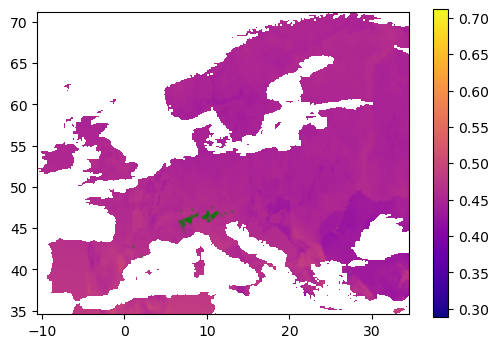

SpeciesId: 7611 ; Num samples: 93 0.45483848452568054 0.7053235769271851


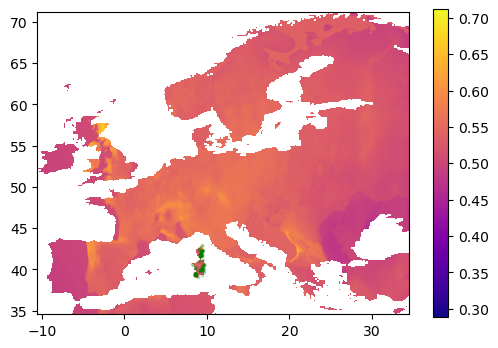

SpeciesId: 3618 ; Num samples: 1000 0.36195316910743713 0.5035295486450195


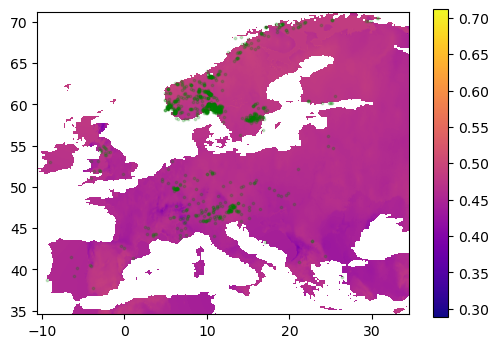

SpeciesId: 4325 ; Num samples: 1000 0.2881510853767395 0.5081247687339783


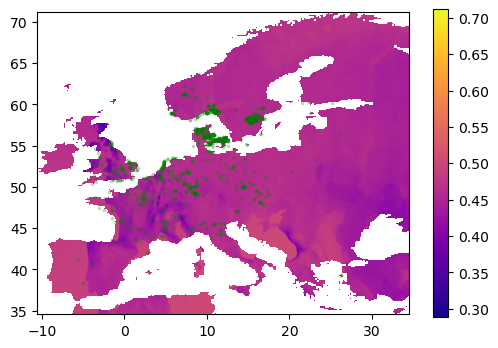

SpeciesId: 8856 ; Num samples: 272 0.4650704562664032 0.6445997953414917


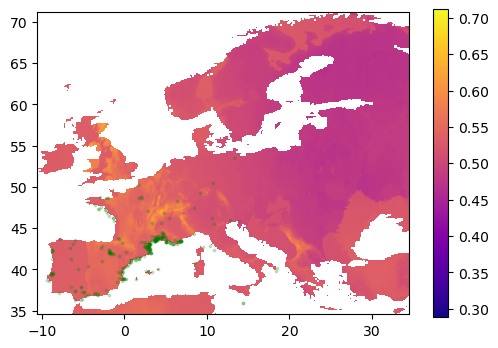

In [23]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
import numpy as np
import os

europa = Image.open("/home/jdolli/geolifeclef_playground/sinr_experiments/europe.png")

vmin = min(preds[:, to_map].min(), 1 - preds[:, to_map].max())
#vmin = 0
vmax = max(preds[:, to_map].max(), 1 - preds[:, to_map].min())

for sid in range(NUM_SAMPLES):
    occs = dataset_file.query("speciesId == " + str(to_map[sid]))
    assert len(occs) == num_samples[sid]
    lon_occs = occs["lon"].to_numpy()
    lat_occs = occs["lat"].to_numpy()
    # lon, lat = dataset._normalize_loc_to_uniform(lon, lat)
    
    mask = np.load(os.path.join("/data/jdolli/glc23_data/sinr_data/data/masks", 'ocean_mask_hr.npy'))
    lon_res = mask.shape[1] / 360
    lat_res = mask.shape[0] / 180
    north = int((90-max_lat) * lat_res)
    south = int((90-min_lat) * lat_res)
    west = int((180 + min_lon) * lon_res)
    east = int((180 + max_lon) * lon_res)
    mask = mask[north:south, west:east]

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlim([-10.53904, 34.55792])
    ax.set_ylim([34.56858, 71.18392])
    cmap = plt.cm.plasma
    cmap.set_bad(color='none')
    mask_inds = np.where(mask.reshape(-1) == 1)[0]
    
    im = preds[:, to_map[sid]]
    print("SpeciesId:", to_map[sid], "; Num samples:", num_samples[sid], im.min().item(), im.max().item())
    im = torch.rot90(im.view(RES_LON, RES_LAT))
    im = torch.reshape(im, (RES_LAT * RES_LON, 1))
    im = im[mask_inds]
    
    op_im = np.ones(mask.shape[0] * mask.shape[1]) * np.nan
    op_im[mask_inds] = im.detach().view(len(mask_inds)).numpy()
    op_im = np.ma.masked_invalid(op_im)
    op_im = op_im.reshape(RES_LAT, RES_LON)
    im = ax.imshow(op_im, extent=(-10.53904, 34.55792, 34.56858, 71.18392), vmin=vmin, vmax=vmax, cmap=cmap)
    ax.scatter(lon_occs, lat_occs, c="green", alpha=0.2, s=3)
    
    fig.colorbar(im, ax=ax)
    
    plt.show()
    

Alia

In [ ]:
# Saving presence absence into tensor

tps1 = pd.read_csv('/data/jdolli/glc23_data/Presence_Absence_surveys/train_pa_spAround_1km.csv', sep=";", header='infer', low_memory=False)
ept = pd.read_csv('/data/jdolli/glc23_data/Presence_Absence_surveys/enviroTab_pa_train.csv', sep=";", header='infer', low_memory=False)

from collections import defaultdict
patch_year_to_species = defaultdict(list)
for entid in tps1.iterrows():
    _, ent = entid
    patch_year_to_species[str(ent["patchID"]) + "/" + str(ent["dayOfYear"])] += [int(ent["speciesId"])]
loc_to_spec = dict()
for paye in patch_year_to_species.keys():
    pa = paye.split("/")[0]
    ye = paye.split("/")[1]
    idx = ept.query(f"patchID == " + str(pa) + " and dayOfYear == " + str(ye))
    assert len(idx) == 1
    loc = idx[["lon", "lat", "dayOfYear"]].to_numpy()
    loc_to_spec[str(loc[0, 0]) + "/" + str(loc[0, 1]) + "/" + str(loc[0, 2])] = patch_year_to_species[paye]
import json
with open('/data/jdolli/glc23_data/Presence_Absence_surveys/loc_to_spec.csv', "w") as f:
    json.dump(dict(loc_to_spec), f)  

In [ ]:
raster.shape